In [1]:
import bz2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import gzip
from heapq import heappushpop
from joblib import Parallel, delayed
import time

In [2]:
dataset_ids = []
dataset_vals = []
for data_id in range(10):
    st = time.time()
    dataset_val = []
    with gzip.open('YFCC100M_hybridCNN_gmean_fc6_%d.txt.gz' % data_id , 'rb') as f:
        times = 0
        dist_gt = []
        for line in tqdm(f):
            line = line.decode()
            tokens = line.split('\t')
            if len(tokens) < 2:
                continue
            trn_id = tokens[0]
            trn_val = np.array([float(token) for token in tokens[2:]], dtype=np.float32)
            dataset_ids.append(trn_id)
            dataset_val.append(trn_val)
    dataset_val = np.array(dataset_val)
    dataset_vals.append(dataset_val)
    print(time.time() - st)


1367.4303152561188



1328.4325828552246



1327.7494022846222



1293.4842503070831



1365.7271945476532



1373.8405306339264



1379.752290725708



1373.0387744903564



1379.2927985191345



1392.4673388004303


In [3]:
dataset_ids_set = set(dataset_ids)
file = 'yfcc100m_autotags.bz2'

zero_label = 0
source_file = bz2.BZ2File(file, "r")
times = 0
dataset_label = {}

for line in tqdm(source_file):
    string = line.decode()
    string = string.split('\t')
    key = string[0]
    value = string[1].split(',')
    words = list(map(lambda x: x.split(':')[0], value))
    try:
        probs = list(map(lambda x: x.split(':')[1], value))
    except:
        zero_label += 1
        # not record this into dataset
        continue
    
    if key in dataset_ids_set:
        dataset_label[key] = set(words)
source_file.close()

In [4]:
dataset_y = [dataset_label[x] if x in dataset_label else set() for x in dataset_ids]

In [5]:
del dataset_label

In [6]:
x_tst = dataset_vals[0][:100]
y_tst = dataset_y[:100]

x_val = dataset_vals[0][100:1100]
y_val = dataset_y[100:1100]

In [7]:
class X:
    def __init__(self, data, offset):
        self.data = data
        self.offset = offset
    
    def __getitem__(self, key):
        index1 = (key + self.offset) // 1000000
        index2 = (key + self.offset) % 1000000
        return self.data[index1][index2]
    
    def __len__(self):
        l = 0
        for x in self.data:
            l += len(x)
        return l - self.offset
    
x_trn = X(dataset_vals, 1100)
y_trn = dataset_y[1100:]

In [8]:
print(len(x_trn))
print(len(y_trn))

9998900
9998900


In [9]:
from tqdm import tqdm_notebook as tqdm
def get_true_KNN(x_trn,x_tst,K):
    N = len(x_trn)
    N_tst = len(x_tst)
    x_tst_knn_gt = np.zeros((N_tst, N))
    for i_tst in tqdm(range(N_tst)):
        dist_gt = np.zeros(N)
        for i_trn in tqdm(range(N)):
            dist_gt[i_trn] = np.linalg.norm(x_trn[i_trn] - x_tst[i_tst], 2)
#             if i_trn % 100000 == 0:
#                 print(i_trn)
        x_tst_knn_gt[i_tst, :] = np.argsort(dist_gt)
    return x_tst_knn_gt.astype(int)

In [10]:
x_val2 = x_val[:100]
y_val2 = y_val[:100]

In [11]:
start = time.time()
x_tst_knn_gt = get_true_KNN(x_trn, x_tst, 1)
end1 = time.time() - start
print(end1)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




16616.27086162567


In [12]:
start = time.time()
x_val_knn_gt = get_true_KNN(x_trn, x_val2, 1)
val_end1 = time.time() - start
print(val_end1)


16918.906363487244


In [13]:
def equal(a, b):
    try:
        return not set.isdisjoint(a, b)
    except KeyError:
        return 0
    
def compute_single_unweighted_knn_class_shapley(x_trn,y_trn,x_tst_knn_gt,y_tst,K):
    N = len(x_trn)
    N_tst = len(x_tst_knn_gt)
    sp_gt = np.zeros((N_tst,N))
    for j in tqdm(range(N_tst)):
        sp_gt[j,x_tst_knn_gt[j,-1]] = equal(y_trn[x_tst_knn_gt[j,-1]], y_tst[j])/N
        for i in tqdm(np.arange(N-2,-1,-1)):
            sp_gt[j,x_tst_knn_gt[j,i]] = sp_gt[j,x_tst_knn_gt[j,i+1]] +\
                           (equal(y_trn[x_tst_knn_gt[j,i]], y_tst[j]) -
                            equal(y_trn[x_tst_knn_gt[j,i+1]], y_tst[j]))/K* min([K,i+1])/(i+1)
    return sp_gt

In [14]:
K = 1
start3 = time.time()
sp_gt = compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_tst_knn_gt, y_tst, K)
end3 = time.time() - start3

In [15]:
start = time.time()
val_sp_gt = compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_val_knn_gt, y_val2, 1)
val_end2 = time.time() - start

In [16]:
np.save('10M/eps0.1/sp_gt', sp_gt)
np.save('10M/eps0.1/val_sp_gt', val_sp_gt)

In [19]:
K = 10
dist_rand = np.load('10M/eps0.1/dist_rand.npy') 
contrast = np.load('10M/eps0.1/contrast.npy')
dist_knn = np.load('10M/eps0.1/dist_knn.npy')

dist_rand = np.mean(dist_rand, axis=0)
contrast = np.mean(contrast, axis=0)[K-1]
dist_knn = np.mean(dist_knn, axis=0)[K-1]

In [20]:
search_range = np.arange(1e-3, 10, 1e-3)
from scipy.stats import norm


def f_h(x, r):
    y = 1-2*norm.cdf(-r/x) - 2/(np.sqrt(2*np.pi)*r/x)*(1-np.exp(-(r**2/(2*(x**2)))))
    return y

def g_unnormalize(dist_rand,dist_knn,r):
    y = np.log(f_h(dist_knn,r))/np.log(f_h(dist_rand,r))
    return y

def g_normalize(contrast,r):
    y = np.log(f_h(1/contrast,r))/np.log(f_h(1,r))
    return y

def find_best_r_normalize(search_range,contrast):
    y = g_normalize(contrast,search_range)
    min_ind = np.argmin(y)
    return search_range[min_ind]

def find_best_r_unnormalize(search_range,dist_rand,dist_knn):
    y = g_unnormalize(dist_rand,dist_knn,search_range)
    min_ind = np.argmin(y)
    return search_range[min_ind]

r_vec_normalize = find_best_r_normalize(search_range, contrast)
g_vec = g_normalize(contrast, r_vec_normalize)

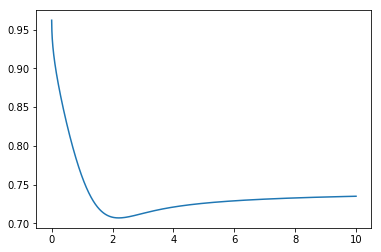

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot g(C_K) vs r, we want g(C_k) to be small
g = g_normalize(contrast,search_range)
plt.figure()
plt.plot(search_range,g)
plt.show()


In [22]:
# search range, find r that minimize g, shape should be 类似 convex

# np.save('data/mnist_mini_selected_param_r_' + str(K) + '.npy', r_vec_normalize)
# np.save('data/mnist_mini_selected_param_g_' + str(K) + '.npy', g_vec)
np.save('10M/eps0.1/selected_param_r_' + str(K) + '.npy', r_vec_normalize)
np.save('10M/eps0.1/selected_param_g_' + str(K) + '.npy', g_vec)

In [23]:
t = r_vec_normalize
n_trn = len(x_trn)
n_hash_table = 10 # 如果 estimation error 高于 0.01
n_hash_bit = int(np.ceil(np.log(n_trn)*0.5/ np.log(1 / f_h(1, t))))
print(n_hash_bit)

19


In [24]:
import numpy as np
import pdb


def lsh_function(t,x,w,b):
    # x is 1-d array
    h = np.floor((np.dot(w,x)+b)/t).astype(int)
    return h


class LSH:
    def __init__(self,n_hash_bit,n_hash_table,x_trn,y_trn,t=0.1):
        self.n_hash_bit = n_hash_bit
        self.n_hash_table = n_hash_table
        self.t = t # width of projections
        self.x_trn = x_trn
        self.y_trn = y_trn
        self.N = len(x_trn)
        self.dim = 4096
        # draw w from a normal distribution (2-stable)
        self.w = np.random.normal(0, 1, (n_hash_table, n_hash_bit, self.dim))
        # draw b from U[0,t]
        self.b = np.random.uniform(0, self.t, (n_hash_table, n_hash_bit))
        self.x_trn_hash = [dict() for i in range(n_hash_table)]
        for i in tqdm(range(self.N)):
            hash_code_all = lsh_function(self.t, x_trn[i] / dist_rand, self.w, self.b)
            for l in range(n_hash_table):
                hash_code_trn = '.'.join(map(str, hash_code_all[l, :]))
                if hash_code_trn in self.x_trn_hash[l].keys():
                    self.x_trn_hash[l][hash_code_trn].append(i)
                else:
                    self.x_trn_hash[l][hash_code_trn] = [i]
#             if i % 1000 == 0:
#                 print('build hash %s'%i)

    def get_approx_KNN(self,x_tst,K):
        N_tst = x_tst.shape[0]
        x_tst_knn = np.ones((N_tst, K)) * (-1)
        nns_len = np.zeros(N_tst)
        for i_tst in tqdm(range(N_tst)):
            nns = []
            for l in range(self.n_hash_table):
                hash_code_int = lsh_function(self.t, x_tst[i_tst] / dist_rand, self.w[l, :, :], self.b[l, :])
                hash_code_test = '.'.join(map(str, hash_code_int))
                if hash_code_test in self.x_trn_hash[l].keys():
                    nns += self.x_trn_hash[l][hash_code_test]
            nns = np.unique(nns)
            num_collide_elements = len(nns)
            if len(nns) > 0:
                dist = [np.linalg.norm(self.x_trn[i] / dist_rand - x_tst[i_tst] / dist_rand, 2) for i in nns]
                dist_min_ind = nns[np.argsort(dist)]
                if num_collide_elements < K:
                    x_tst_knn[i_tst, :num_collide_elements] = dist_min_ind[:num_collide_elements]
                else:
                    x_tst_knn[i_tst, :] = dist_min_ind[:K]
            # pdb.set_trace()
            nns_len[i_tst] = len(nns)
            if i_tst % 100 == 0:
                print('get approximate knn %s'%i_tst)
        return x_tst_knn.astype(int),nns_len


    def compute_approx_shapley(self,x_tst_knn,y_tst,K):
        N_tst,K_star = x_tst_knn.shape
        # flag_sufficient = (x_tst_knn[:,-1]>=0)
        sp_approx = np.zeros((N_tst,self.N))
        for j in tqdm(range(N_tst)):
            non_nan_index = np.where(x_tst_knn[j,:]>=0)[0]
            if len(non_nan_index)== 0:
                continue
            K_tot = non_nan_index[-1]
            if K_tot == self.N:
                sp_approx[j, x_tst_knn[j, self.N - 1]] = equal(self.y_trn[x_tst_knn[j, self.N - 1]], y_tst[j]) / self.N
            for i in np.arange(K_tot - 1, -1, -1):
                sp_approx[j, x_tst_knn[j, i]] = sp_approx[j, x_tst_knn[j, i+1]] + (
                        equal(self.y_trn[x_tst_knn[j, i]], y_tst[j]) - equal(
                    self.y_trn[x_tst_knn[j, i + 1]], y_tst[j])) / K * min([K, i + 1]) / (i + 1)



        return sp_approx

In [25]:
def equal(a, b):
    try:
        return not set.isdisjoint(a, b)
    except KeyError:
        return 0
    
def fine_tune(n_hash_table=10, alpha=0.5, file=False):
    t = r_vec_normalize
    n_trn = len(x_trn)
    n_hash_bit = int(np.ceil(np.log(n_trn)*alpha/ np.log(1 / f_h(1, t))))
    if file is True:
        print(n_hash_bit, file=open('10M/log.txt', 'a'))
    else:
        print(n_hash_bit)
    
    start = time.time()
    lsh = LSH(n_hash_bit=n_hash_bit, n_hash_table=n_hash_table, x_trn=x_trn, y_trn=y_trn, t=t)
    runtime_build_hash = time.time() - start
    if file is True:
        print(runtime_build_hash, file=open('10M/log.txt', 'a'))
    else:
        print(runtime_build_hash)
    
    K_star = 10
    start = time.time()
    x_val_knn_approx, nns_vec = lsh.get_approx_KNN(x_val2, K_star)
    runtime_query = time.time() - start
    if file is True:
        print(runtime_query, file=open('10M/log.txt', 'a'))
    else:
        print(runtime_query)
    
    K = 1
    start = time.time()
    sp_approx = lsh.compute_approx_shapley(x_val_knn_approx, y_val2, K)
    runtime_approx_value = time.time() - start
    if file is True:
        print('it takes %s to get appox knn value' % runtime_approx_value, file=open('10M/log.txt', 'a'))
    else:
        print('it takes %s to get appox knn value' % runtime_approx_value)
    
    sp_err_inf_val= np.linalg.norm(val_sp_gt - sp_approx,ord=np.inf, axis=1)
    if file is True:
        print('max error %s'% np.percentile(sp_err_inf_val,90), file=open('10M/log.txt', 'a'))
    else:
        print('max error %s'% np.percentile(sp_err_inf_val,90))
    return lsh

In [27]:
def fine_tune_test(n_hash_table=10, lsh=None, file=False):
    if not lsh:
        t = r_vec_normalize
        n_trn = len(x_trn)
        n_hash_bit = int(np.ceil(np.log(n_trn)*0.3/ np.log(1 / f_h(1, t))))
        print(n_hash_bit)
    
        start = time.time()
        lsh = LSH(n_hash_bit=n_hash_bit, n_hash_table=n_hash_table, x_trn=x_trn_norm, y_trn=y_trn, t=t)
        runtime_build_hash = time.time() - start
        print(runtime_build_hash)
    
    K_star = 10
    start = time.time()
    x_tst_knn_approx, nns_vec = lsh.get_approx_KNN(x_tst, K_star)
    runtime_query = time.time() - start
    if file is True:
        print(runtime_query, file=open('10M/log.txt', 'a'))
    else:
        print(runtime_query)
    
    K = 1
    start = time.time()
    sp_approx = lsh.compute_approx_shapley(x_tst_knn_approx, y_tst, K)
    runtime_approx_value = time.time() - start
    if file is True:
        print('it takes %s to get appox knn value' % runtime_approx_value, file=open('10M/log.txt', 'a'))
    else:
        print('it takes %s to get appox knn value' % runtime_approx_value)
    
    sp_err_inf_val= np.linalg.norm(sp_gt - sp_approx,ord=np.inf, axis=1)
    if file is True:
        print('max error %s'% np.percentile(sp_err_inf_val,90), file=open('10M/log.txt', 'a'))
    else:
        print('max error %s'% np.percentile(sp_err_inf_val,90))
    return sp_approx, nns_vec

In [28]:
lsh_71_038 = fine_tune(71, 0.38, file=True)
sp_approx_71_038, nns_vec_71_038 = fine_tune_test(71, lsh_71_038, file=True)

get approximate knn 0


get approximate knn 0


In [29]:
lsh_80_04 = fine_tune(80, 0.4, file=True)
sp_approx_80_04, nns_vec_80_04 = fine_tune_test(80, lsh_80_04, file=True)

get approximate knn 0


get approximate knn 0


In [30]:
np.save('10M/eps0.1/sp_appox_71_038', sp_approx_71_038)

In [ ]:
del sp_approx_71_038
del sp_approx_80_04
del nns_vec_80_04

In [ ]:
lsh_85_04 = fine_tune(85, 0.4, file=True)
sp_approx_85_04, nns_vec_85_04 = fine_tune_test(85, lsh_85_04, file=True)

In [33]:
del lsh_85_04
del sp_approx_85_04, nns_vec_85_04

In [34]:
lsh_75_038 = fine_tune(75, 0.38, file=True)
sp_approx_75_038, nns_vec_75_038 = fine_tune_test(75, lsh_75_038, file=True)

get approximate knn 0


get approximate knn 0


In [35]:
lsh_90_04 = fine_tune(90, 0.4, file=True)
sp_approx_90_04, nns_vec_90_04 = fine_tune_test(90, lsh_90_04, file=True)

get approximate knn 0


get approximate knn 0


In [36]:
del lsh_90_04
del sp_approx_90_04, nns_vec_90_04

In [37]:
import gc
gc.collect()

0

In [39]:
np.save('10M/eps0.1/sp_approx_75_038', sp_approx_75_038)

In [44]:
del dataset_vals

In [45]:
gc.collect()

1022169

In [46]:
np.save('10M/eps0.1/lsh_75_038', lsh_75_038)

OverflowError: cannot serialize a string larger than 4GiB

In [47]:
import joblib
joblib.dump(lsh_75_038, '10M/eps0.1/lsh_75_038.pkl') 

['10M/eps0.1/lsh_75_038.pkl']